In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
import utils
import cv2
import matplotlib.pyplot as plt
from PIL import Image

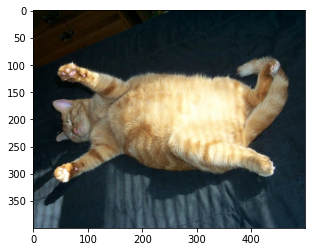

In [2]:
img = cv2.imread(r'../data/img/cat1.jpg')
img = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2RGB)
img = Image.fromarray(img)
plt.imshow(img)

In [3]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    utils.show_images(Y, num_rows, num_cols, scale=scale)

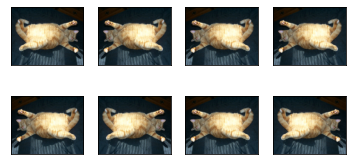

In [4]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

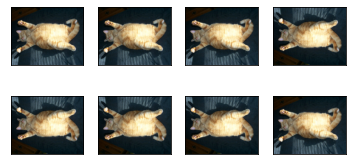

In [5]:
apply(img, torchvision.transforms.RandomVerticalFlip())

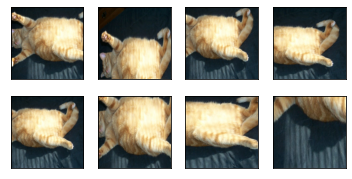

In [6]:
# 裁剪一个面积为原始面积10%到100%的区域，该区域的宽高比从0.5～2之间随机取值。 
# 然后，区域的宽度和高度都被缩放到200像素。
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

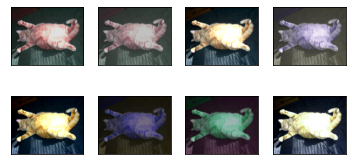

In [7]:
# 随机更改图像的亮度（brightness）、对比度（contrast）、饱和度（saturation）和色调（hue）
# 幅度为0.5，即±50%
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

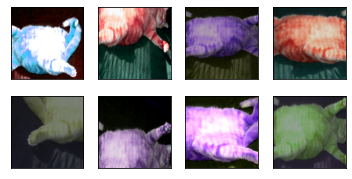

In [8]:
# 组合多种增强方案
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

Files already downloaded and verified


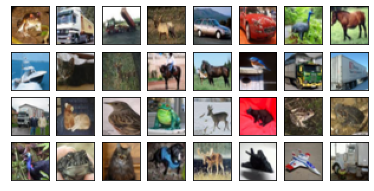

In [9]:
# 使用图像增广进行训练
all_images = torchvision.datasets.CIFAR10(train=True, root="../data", download=True)
utils.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

In [10]:
train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])
# 预测不增广
test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

In [11]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=utils.get_dataloader_workers())
    return dataloader

In [12]:
def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001, epochs=10):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    utils.train_gpus(net, train_iter, test_iter, loss, trainer, epochs, devices)

In [13]:
batch_size, devices, net = 256, utils.try_all_gpus(), utils.resnet18(10, 3)
net.apply(init_weights)
train_with_data_aug(train_augs, test_augs, net)

Files already downloaded and verified
Files already downloaded and verified
epoch: 1/10, loss 1.358, train acc 0.519, test acc 0.447
epoch: 2/10, loss 0.801, train acc 0.716, test acc 0.727
epoch: 3/10, loss 0.591, train acc 0.791, test acc 0.741
epoch: 4/10, loss 0.478, train acc 0.833, test acc 0.806
epoch: 5/10, loss 0.397, train acc 0.862, test acc 0.782
epoch: 6/10, loss 0.333, train acc 0.886, test acc 0.832
epoch: 7/10, loss 0.278, train acc 0.904, test acc 0.839
epoch: 8/10, loss 0.234, train acc 0.919, test acc 0.831
epoch: 9/10, loss 0.205, train acc 0.930, test acc 0.818
epoch: 10/10, loss 0.169, train acc 0.943, test acc 0.841
*** 679.3 examples/sec on [device(type='cuda', index=0)] - [0:00:12:16], all: [0:00:14:01] ***
